AR non-anomaly composites of different variables using different cEOF tests (e.g. DJF, MAM, DJF-MAM). 

Creates significant differences plots for IVT and upper level plots. (e.g. El Nino vs Neutral conditions for each AR type)


## Imports

In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
import nclcmaps as nclc
from timeseries import persistence, select_months, create_list_all_dates
from teleconnections import build_teleconnection_df, mjo_index
from statistical_tests import xr_zscore_diff_mean
from ar_funcs import ar_daily_df

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [4]:
# choose season
ssn = 'djfmam'
ceofid = 'IVT'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [5]:
# import configuration file for dictionary choice
yaml_doc = '../data/config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_diff']
# plot_dict_ivt = config['ivt_diff']
plot_dict_prec = config['precip_diff']
plot_dict_iwv = config['iwv_diff']
plot_dict_500 = config['lower_diff']

plot_dicts = [plot_dict_upper]

# djf_dict mam_dict djfmam_dict
ar_dict = config[ssn]

### AR days and Climate Indices

In [6]:
outpath = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
start_date = '1979-12-01'
end_date = '2019-05-31'

# climate index df
tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
mjo = mjo_index('daily', ar_dict['start_date'], ar_dict['end_date'])
tele['MJO'] = mjo['COND']
df_index = select_months(tele, 12, 5)

df = ar_daily_df(ssn, nk, outpath)
# combine ar df with tele df
# join indices with AR count
new_df = df.join(df_index)
new_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
date,,,,,,,,,,
1979-12-01 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-02 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-03 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-04 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-05 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,0.0,0.0,0.0,0.0,0,0,0,1,1,1
2019-05-28 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1
2019-05-29 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1


In [7]:
idx = (new_df.AR_CAT > 0) 
df_stat = new_df.loc[idx]
df_stat

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
date,,,,,,,,,,
1979-12-01 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-02 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1980-01-24 09:00:00,0.0,0.0,1.0,1.0,3,-1,0,0,0,-1
1980-02-12 09:00:00,0.0,1.0,0.0,1.0,2,-1,1,0,0,-1
1980-02-13 09:00:00,1.0,0.0,0.0,1.0,1,-1,1,0,0,-1
...,...,...,...,...,...,...,...,...,...,...
2019-04-09 09:00:00,0.0,1.0,0.0,1.0,2,-1,0,1,1,1
2019-04-15 09:00:00,0.0,1.0,0.0,1.0,2,0,0,1,1,1
2019-04-16 09:00:00,1.0,0.0,0.0,1.0,1,0,0,1,1,1


In [8]:
cli_lst1 = ['ENSO', 'AO', 'SH']
cli_lst2 = [['AO', 'SH'], ['ENSO', 'SH'], ['ENSO', 'AO']]

for i, (cli1, cli2) in enumerate(zip(cli_lst1, cli_lst2)):
    idx = (df_stat[cli1] == 1) & (df_stat[cli2[0]] == 0) & (df_stat[cli2[1]] == 0)
    subset_df = df_stat.loc[idx]
    print('Number of unique', cli1, 'positive days', len(subset_df))
    
    idx = (df_stat[cli1] == -1) & (df_stat[cli2[0]] == 0) & (df_stat[cli2[1]] == 0)
    subset_df = df_stat.loc[idx] 
    print('Number of unique', cli1, 'negative days', len(subset_df))

Number of unique ENSO positive days 25
Number of unique ENSO negative days 11
Number of unique AO positive days 24
Number of unique AO negative days 42
Number of unique SH positive days 38
Number of unique SH negative days 70


### ERA5 renalysis

In [9]:
rename_dict_upper = {'z': 'H', 
                     'u': 'U250', 
                     'v':'V250', 
                     'q': 'QV',
                     'latitude': 'lat',
                     'longitude': 'lon'}

rename_dict_prec = {'mtpr': 'prec', 
                    'latitude': 'lat',
                    'longitude': 'lon'}

rename_dict_iwv = {'latitude': 'lat',
                    'longitude': 'lon'}

rename_dict_lower = {'z': 'H', 
                     'u': 'U500', 
                     'v':'V500', 
                     'q': 'QV',
                     'latitude': 'lat',
                     'longitude': 'lon'}

In [10]:
def preprocess(ds):
    '''keep only selected lats and lons'''
    if plot_dict['name'] == 'huv250':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
        subset = subset.rename(rename_dict_upper)
        subset = subset.drop(['QV'])
    if plot_dict['name'] == 'prec':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict_prec)
    if plot_dict['name'] == 'huv500':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
        subset = subset.rename(rename_dict_lower)
        subset = subset.drop(['QV', 'H'])
    if plot_dict['name'] == 'iwv':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict_iwv)
        subset = subset.drop(['tcrw', 'tcsw', 'tcw'])
        
    return subset

f = []

# Select lat/lon grid
lonmin = 0
lonmax = 120
latmin = 5
latmax = 60

    
for p, plot_dict in enumerate(plot_dicts):

    # # open data  
    f.append(xr.open_mfdataset(path_to_data + plot_dict['fname'] , preprocess=preprocess, combine='by_coords'))

ds = xr.merge(f[:3], compat='override')
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# f[0]['H'] = f[0]['H']/(9.80665), # convert to geopotential height (m)
# f[1]['prec'] = f[1]['prec']*86400 # convert to mm day-1

ds size in GB 9.61



In [11]:
# import precipitation averages for AR Types
fname = path_to_out+'precip_djfmam_h500_eof2_k3.nc'
precipitation = xr.open_dataset(fname)
precipitation

<xarray.Dataset>
Dimensions:  (ar: 3, lat: 221, lon: 361)
Coordinates:
  * lat      (lat) float32 55.0 54.75 54.5 54.25 54.0 ... 1.0 0.75 0.5 0.25 0.0
  * lon      (lon) float32 20.0 20.25 20.5 20.75 ... 109.25 109.5 109.75 110.0
  * ar       (ar) int64 1 2 3
Data variables:
    prec     (ar, lat, lon) float64 ...

### Combine with data

In [12]:
%%time
df = new_df
ds_lst = [ds]
for i, ds in enumerate(ds_lst):
    # Trim date range
    idx = slice(ar_dict['start_date'], ar_dict['end_date'])
    ds = ds.sel(time=idx)
    
    # Select months
    if ar_dict['mon_s'] > ar_dict['mon_e']:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
    else:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    ds = ds.sel(time=idx)
    
    # Combine AR Cat data w/ reanalysis data
    # Add ar time series to the ERA dataset
    cols = ['AR_CAT', 'AO', 'PDO', 'ENSO', 'SH', 'MJO']
    
    for k, col in enumerate(cols):
        ds[col] = ('time', df[col])

    ds = ds.set_coords(tuple(cols))
    
    print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
    ds = ds.load()
    ds_lst[i] = ds

ds size in GB 4.68

CPU times: user 9.37 s, sys: 3min 8s, total: 3min 17s
Wall time: 6min 32s


### Figures

### Common Plot Properties

In [13]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]


### Composite Plots

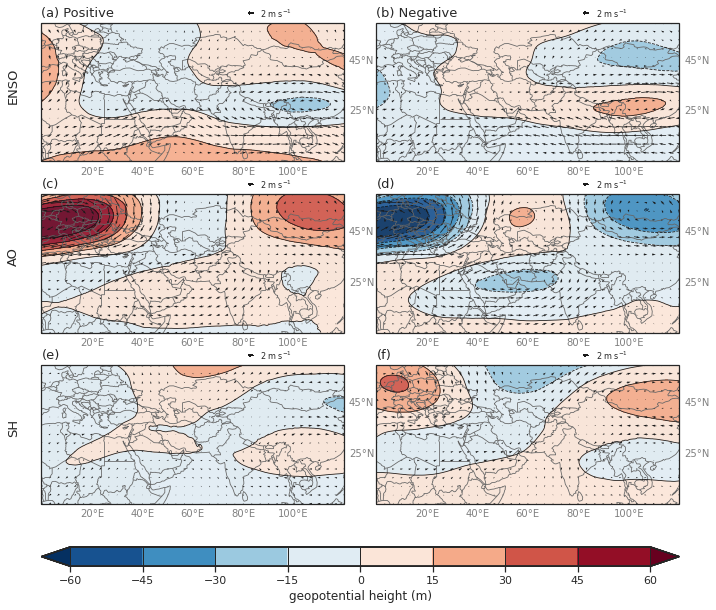

In [14]:

filepath = path_to_figs + 'composite_climate_indices.png'
nrows = 3
ncols = 2
row_lbl = ['ENSO', '', 'AO', '', 'SH', '']
plt_lbl = ['(a) Positive', '(b) Negative', '(c)', '(d)', '(e)', '(f)']
ext1 = [0, 120, 5, 60]

cli_lst = ['ENSO']*2 + ['AO']*2 + ['SH']*2
cond_lst = [1, -1]*3

# Create figure
fig = plt.figure(figsize=(15, 10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
            nrows_ncols=(nrows, 2), axes_pad = 0.45,
            cbar_location='bottom', cbar_mode='single',
            cbar_pad=0.15, cbar_size='7%',label_mode='',
            direction='row')


#################################
########## UPPER PLOTS ##########
#################################
for k, (ax, cli, cond) in enumerate(zip(axgr, cli_lst, cond_lst)):
    idx = (ds_lst[0][cli] == cond)
    data = ds_lst[0].sel(time=idx).mean('time')
    plot_dict = plot_dict_upper
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=False, right_lats=True)

    uvec = data.U250.values
    vvec = data.V250.values
    hgts = data.H.values/(9.80665) # convert to geopotential height (m)

   # Contour Filled (hgts significant)                           
    cflevs = clevs = np.arange(-60, 75, 15)
    cf = ax.contourf(lons, lats, hgts, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='both') 

    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=17, pivot='middle',
                  angles='xy', scale_units='xy', scale=1, units='xy')

    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, 2, '2 m s$^{-1}$', labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})

    # Contour Lines (250-hPa Heights ALL)
    clevs = cflevs
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='k', linewidths=0.8)

    # subtitles
    ax.set_title(plt_lbl[k], loc='left',fontsize=13)
    # Row labels
    ax.text(-0.07, 0.55, row_lbl[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)

    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label(plot_dict['cb_label'])


# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


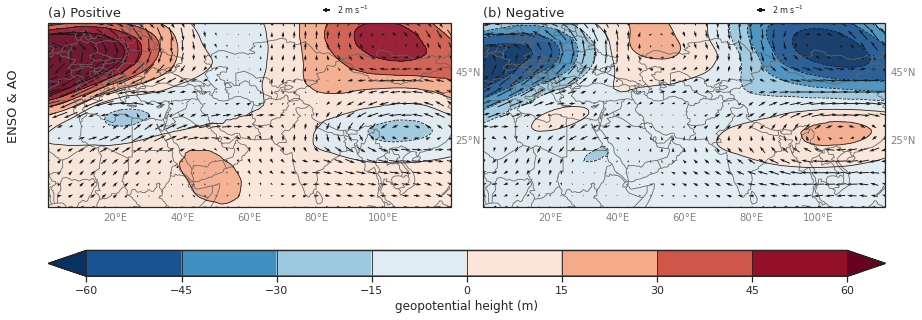

In [16]:

filepath = path_to_figs + 'composite_climate_indices_AO_ENSO.png'
nrows = 1
ncols = 2
row_lbl = ['ENSO & AO', '']
plt_lbl = ['(a) Positive', '(b) Negative', '(c)', '(d)', '(e)', '(f)']

cond_lst = [1, -1]

# Create figure
fig = plt.figure(figsize=(15, 10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
            nrows_ncols=(nrows, 2), axes_pad = 0.45,
            cbar_location='bottom', cbar_mode='single',
            cbar_pad=0.15, cbar_size='7%',label_mode='',
            direction='row')


#################################
########## UPPER PLOTS ##########
#################################
for k, (ax, cond) in enumerate(zip(axgr, cond_lst)):
    idx = (ds_lst[0]['ENSO'] == cond) & (ds_lst[0]['AO'] == cond)
    data = ds_lst[0].sel(time=idx).mean('time')
    plot_dict = plot_dict_upper
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=False, right_lats=True)

    uvec = data.U250.values
    vvec = data.V250.values
    hgts = data.H.values/(9.80665) # convert to geopotential height (m)

   # Contour Filled (hgts significant)                           
    cflevs = clevs = np.arange(-60, 75, 15)
    cf = ax.contourf(lons, lats, hgts, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='both') 

    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=17, pivot='middle',
                  angles='xy', scale_units='xy', scale=1, units='xy')

    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, 2, '2 m s$^{-1}$', labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})

    # Contour Lines (250-hPa Heights ALL)
    clevs = cflevs
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='k', linewidths=0.8)

    # subtitles
    ax.set_title(plt_lbl[k], loc='left',fontsize=13)
    # Row labels
    ax.text(-0.07, 0.55, row_lbl[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)

    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label(plot_dict['cb_label'])


# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
